In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import gcsfs
import fsspec
import os
import sys
sys.path.append(os.path.abspath(os.path.join('diffusionsim')))
fs = gcsfs.GCSFileSystem()

user_path = "gs://leap-persistent/sammyagrawal"

fs.ls(user_path)

['leap-persistent/sammyagrawal/input_climsim.npy',
 'leap-persistent/sammyagrawal/output_climsim.npy']

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import diffusionsim as diff
from diffusionsim.climsim_training_utils import train_test_split
from diffusionsim.mydatasets import ClimsimDataset
from diffusionsim.models import load_model

In [4]:
X, Y = diff.load_numpy_arrays()

Finished Loading X from gs://leap-persistent/sammyagrawal/input_climsim.npy
Finished Loading Y from gs://leap-persistent/sammyagrawal/output_climsim.npy


In [5]:
Xarr, Yarr = diff.reconstruct_xarr_from_npy(
    X, Y, 
    subsampling=(36,210240, 144), 
    data_vars='v1', 
)

In [6]:
config = diff.TrainingConfig()

config.batch_size = 64
config.batch_logging_interval = 20
config.distributed_training = False # single GPU training
config.learning_rate = 3e-4
config.phases = ['train']
config.train_test_split = [0.01, 0.005]
config.beta = 0.05
config

TrainingConfig(model_type='VAE', run_id='vae', num_channels=128, latent_dims=16, ae_hidden_dims=[64, 32, 16], dataset_type='ClimsimDataset', data_base_path='gs://leap-persistent/sammyagrawal/', train_test_split=[0.01, 0.005], data_paths=['gs://leap-persistent/sammyagrawal/input_climsim.npy', 'gs://leap-persistent/sammyagrawal/output_climsim.npy'], data_vars='v1', xarr_subsamples=(36, 210240, 144), optimizer='adam', phases=['train'], distributed_training=False, shuffle_data={'train': True, 'eval': False}, batch_size=64, learning_rate=0.0003, beta=0.05, save_best_epoch=True, batch_logging_interval=20, log_gradients=True)

In [7]:
datasets = train_test_split(Xarr, Yarr, split_frac=config.train_test_split)

In [8]:
xtrain, ytrain = datasets[0]
xtest, ytest = datasets[1]

In [9]:
xtrain

<xarray.DataArray (state: 5606, mli: 124)> Size: 6MB
array([[ 2.16085190e+02,  2.18792013e+02,  2.33851897e+02, ...,
         6.44691415e+01,  1.84509528e+02, -1.12736283e+01],
       [ 2.19178299e+02,  2.22322752e+02,  2.34573009e+02, ...,
         9.20508201e+02,  2.71057195e+02,  1.92170450e+01],
       [ 2.21398212e+02,  2.34226792e+02,  2.36312568e+02, ...,
         6.67362298e+02,  2.82170643e+02,  1.03419090e+02],
       ...,
       [ 2.14106835e+02,  2.24090653e+02,  2.30463904e+02, ...,
         7.23468700e+02,  3.02156867e+01,  9.31103503e-01],
       [ 2.15272190e+02,  2.33188513e+02,  2.31785815e+02, ...,
         1.30831990e+03,  1.73666393e+02,  9.55735452e+00],
       [ 2.15198251e+02,  2.33746035e+02,  2.36914477e+02, ...,
         6.69229985e+02,  4.50876864e+01,  2.94280597e+00]])
Coordinates:
  * state     (state) object 45kB MultiIndex
  * sample    (state) int64 45kB 113 434 353 1383 987 152 ... 1118 0 703 588 41
  * ncol      (state) int64 45kB 103 109 183 242 197 292 ... 92 236 75 170 210
  * mli       (mli) object 992B MultiIndex
  * variable  (mli) object 992B 'state_t' 'state_t' ... 'pbuf_SHFLX'
  * lev       (mli) object 992B 0 1 2 3 4 5 6 7 ... 56 57 58 59 nan nan nan nan

In [10]:
train_ds, test_ds = ClimsimDataset(xtrain, ytrain, device), ClimsimDataset(xtest, ytest, device)

Normalizing data
Normalizing data


In [11]:
datasets = {'train': train_ds, 'eval':test_ds}

In [12]:
train_ds.X.shape, test_ds.Y.shape

(torch.Size([5606, 124]), torch.Size([2803, 128]))

##### Baselines

We can now set 0.0424 as a baseline mean squared error; if our VAE does not come close to that, might we well use PCA

In [ ]:
from sklearn.decomposition import PCA
#pca = PCA(n_components=config.latent_dims)

In [ ]:
ytest.data.shape # n_samples x size

In [ ]:
PCA.fit(X=train_ds.Y)

In [ ]:
y_embedded = PCA.transform(test_ds.Y)
y_rec = PCA.inverse_transform(y_embedded)

y_embedded.shape, y_rec.shape

In [ ]:
loss_fn(torch.tensor(y_rec), test_ds.Y)

In [ ]:
test_ds.Y.shape

In [ ]:
list(test_ds.mli.values).index(('state_t', 6))

In [ ]:
losses = []
latent_sizes = [2, 4, 8, 12, 16, 24, 32, 64, 128]
for latent_size in latent_sizes:
    pca = PCA(n_components=latent_size)
    pca.fit(X=train_ds.Y)
    y_embedded = pca.transform(test_ds.Y)
    y_rec = pca.inverse_transform(y_embedded)
    losses.append(loss_fn(torch.tensor(y_rec), test_ds.Y))



In [ ]:
list(zip(latent_sizes, losses))

In [ ]:
plt.plot(losses)
plt.xlabel("Latent Dimensionality")
plt.ylabel("Reconstruction MSE")
plt.show()

In [ ]:
pca = PCA(n_components=2)
pca.fit(X=train_ds.Y)
y_embedded = pca.transform(test_ds.Y)
y_rec = pca.inverse_transform(y_embedded)
loss_fn(torch.tensor(y_rec), test_ds.Y)

In [ ]:
test_ds.Y

In [ ]:
plt.scatter(y_embedded[:,0], y_embedded[:,1])

## Defining Things for Testing

In [13]:
import torch.nn.functional as F

In [14]:

class VariationalEncoder(torch.nn.Module):
    """
    Conditional VAE Encoder with <layers>+1 fully connected layer
    """
    def __init__(self, in_dims, hidden_dims=[64, 32, 16], latent_dims=16, dropout=0, device='cpu'):
        super().__init__()

        self.linears = nn.ModuleList([nn.Linear(in_dims, hidden_dims[0])])
        for j in range(len(hidden_dims)-1):
            self.linears.append(nn.Linear(hidden_dims[j], hidden_dims[j+1]))
                
            #self.linears += [torch.nn.Sequential(
            #    torch.nn.Linear(in_dims if i == 0 else hidden_dims, hidden_dims),
            #    torch.nn.LayerNorm(hidden_dims),
            #    torch.nn.Dropout(p=dropout))
            #    ]
        self.enc_mean = torch.nn.Linear(hidden_dims[-1], latent_dims)
        self.enc_logstd = torch.nn.Linear(hidden_dims[-1], latent_dims, bias=False)
        self.kl = 0
        self.device = device

    def forward(self, x):
        #if (type(x) != torch.Tensor):
        #    x = torch.tensor(x, dtype=torch.float32, )
        #z = torch.flatten(x.squeeze(), start_dim=1)
        z = x.squeeze()
        for linear in self.linears:
            z = F.relu(linear(z))
        mu, sigma = self.enc_mean(z), torch.exp(self.enc_logstd(z)) # ensures sigma is always positive
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).mean() # mean so that kl div comparable to mse
        return(mu, sigma)

class Decoder(torch.nn.Module):
    """
    Conditional VAE Decoder with <layers>+1 fully connected layer
    """
    def __init__(self, out_dims, hidden_dims=[16, 32, 64], latent_dims=16):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(latent_dims, hidden_dims[0])])
        for j in range(len(hidden_dims)-1):
            self.linears.append(nn.Linear(hidden_dims[j], hidden_dims[j+1]))
        self.dec_mu = nn.Linear(hidden_dims[-1], out_dims)
        #self.dec_std = torch.nn.Linear(hidden_dims[-1], out_dims)

    def forward(self, z):
        for linear in self.linears:
            z = torch.nn.functional.relu(linear(z))
        mu = self.dec_mu(z)
        #sig = torch.exp(self.dec_std(z))
        return mu


In [15]:
class VariationalAutoencoder(torch.nn.Module):
    def __init__(self, data_dims=128, label_dims=128,
                 latent_dims=16, hidden_dims=[64, 32, 16], device='cpu'):
        """
        Conditional VAE
        Encoder: [y x] -> [mu/sigma] -sample-> [z]
        Decoder: [z x] -> [y_hat]

        Inputs:
        -------
        beta - [float] trade-off between KL divergence (latent space structure) and reconstruction loss
        data_dims - [int] size of x
        label_dims - [int] size of y
        latent_dims - [int] size of z
        hidden_dims - [int] size of hidden layers
        layers - [int] number of layers, including hidden layer
        """
        super().__init__()
        self.latent_dims = latent_dims
        self.label_dims = label_dims
        self.encoder = VariationalEncoder(data_dims, hidden_dims, latent_dims)
        decoder_hidden = list(reversed(hidden_dims))
        self.decoder = Decoder(data_dims, decoder_hidden, latent_dims)
        self.move_device(device)

        self.N = torch.distributions.Normal(0, 1)
        #self.N.loc = self.N.loc.to(device)
        #self.N.scale = self.N.scale.to(device)

    def move_device(self, new_device):
        self.device = new_device
        self = self.to(new_device)

    def forward(self, x, sample=True):
        # Normalize
        #if batch_norm:
        #    x_m, x_s = x.mean(axis=0), x.std(axis=0)
        #    mx = x_s != 0
        #    x[:, mx] = (x[:, mx] - x_m[mx]) / x_s[mx] 
            
        mu, sigma = self.encoder(x)
        if(sample):
            z = mu + sigma * torch.randn(sigma.shape, device=self.device)
        else:
            z = mu
        x_hat = self.decoder(z)
            #if batch_norm:
            #    y_hat_mean = (y_hat_mean + y_m) * y_s
        return x_hat

    def sample(self, x, random=True):
        """
        Sample conditionally on x

        Inputs:
        -------
        x - [BxN array] label
        random - [boolean] if true sample latent variable from prior else use all-zero vector
        """
        if random:
            # Draw from prior
            z = self.encoder.N.sample([x.shape[0], self.latent_dims])
        else:
            # Set to prior mean
            z = torch.zeros([x.shape[0], self.latent_dims]).to(device)
        mean_y, std_y = self.decoder(z, x)
        if random:
            # add output noise
            y = mean_y + self.N.sample(mean_y.shape) * std_y
            # y = torch.zeros_like(mean_y)
            # nz = torch.rand(y.shape).to(device) > p0
            # y[nz] = mean_y[nz] + self.encoder.N.sample([(nz == 1).sum()]) * std_y[nz]
            return y
        else:
            return mean_y, std_y







In [16]:
config.ae_hidden_dims, config.num_channels, config.latent_dims

([64, 32, 16], 128, 16)

In [17]:
def load_model(config, device):
    registered = ['VAE']
    match config.model_type:
        case "VAE":
            model = VariationalAutoencoder(
                data_dims= config.num_channels, 
                latent_dims= config.latent_dims, 
                hidden_dims= config.ae_hidden_dims, 
                device = device,
            )
        case _:
            # diffusion model
            print("model not found, try one of ", registered)
            pass
    return(model)

In [18]:
model = load_model(config, device)
model

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linears): ModuleList(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=16, bias=True)
    )
    (enc_mean): Linear(in_features=16, out_features=16, bias=True)
    (enc_logstd): Linear(in_features=16, out_features=16, bias=False)
  )
  (decoder): Decoder(
    (linears): ModuleList(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=64, bias=True)
    )
    (dec_mu): Linear(in_features=64, out_features=128, bias=True)
  )
)

In [19]:
optim = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
loss_fn = torch.nn.MSELoss()
optim, loss_fn

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.0003
     maximize: False
     weight_decay: 0
 ),
 MSELoss())

In [25]:
class VAETrainer(diff.trainers.AbstractTrainer):
    def __init__(self, model, datasets, loss_fn, config, rank = 0, exp_id='VAE'):
        """
        Trainer Class for VAE Training
        """
        # abstract trainer: model, datasets, loss, config, exp, rank
        super().__init__(model, datasets, loss_fn, config, exp_id, rank)
        #if(not hasattr(config, "beta")):
            #self.config.beta = 0.5

    def setup_training(self, num_epochs):
        super().setup_training(num_epochs)
        self.losses = {}
        for phase in self.phases:
            self.losses[phase] = {'mse':[], 'kl':[]}
        self.best_loss = 10
        if(self.config.log_gradients):
            self.gradients = dict(kl_gradients={}, mse_gradients = {})
            for name, param in self.model.named_parameters():
                self.gradients['kl_gradients'][name] = []
                self.gradients['mse_gradients'][name] = []

        self.batches_per_epoch = len(self.dataloaders['train'])

        self.eval_losses = dict(mse=[], kl=[])

    def _run_batch(self, batch, phase):
        x_hat = self.model(batch)
        kl_div = self.model.encoder.kl
        mse = self.loss_fn(batch, x_hat)# + self.config.beta * kl_div
        if(phase == 'train'):
            self.optimizer.zero_grad()
            if(self.config.log_gradients):
                # Compute and store gradients for MSE
                mse.backward(retain_graph=True)
                for name, p in self.model.named_parameters():
                    self.gradients['mse_gradients'][name].append(p.grad.mean().item())
                self.optimizer.zero_grad()  # Clear the gradients again
    
                # Compute and store gradients for KL divergence
                (self.config.beta*kl_div).backward(retain_graph=True)
                for name, p in self.model.encoder.named_parameters():
                    name = "encoder." + name
                    self.gradients['kl_gradients'][name].append(p.grad.mean().item())
                self.optimizer.zero_grad()  # Clear the gradients again
            
            # Combine the loss and backpropagate
            total_loss = mse + self.config.beta * kl_div
            total_loss.backward()
            self.optimizer.step()

        return(x_hat, mse, kl_div)

    def _run_train_epoch(self, epoch):
        mse_loss, kl_div = 0.0, 0.0
        self.model.train(True)
        with torch.set_grad_enabled(True):
            if(self.distributed):
                dataloader.sampler.set_epoch(epoch)
            for step, batch in enumerate(self.dataloaders['train']):
                x_hat, mse, kl = self._run_batch(batch, 'train')
                mse_loss += mse.item()
                kl_div += kl.item()
                if((step+1) % self.config.batch_logging_interval == 0):
                    mse_loss = mse_loss / self.config.batch_logging_interval
                    kl_div =  kl_div / self.config.batch_logging_interval
                    self._log_step('train', mse_loss, kl_div, step)
                    mse_loss, kl_div = 0.0, 0.0
            remainder_steps = self.batches_per_epoch % self.config.batch_logging_interval
            self._log_step('train', mse_loss/remainder_steps, kl_div/remainder_steps, self.batches_per_epoch)
        return(0)

    def _run_eval_epoch(self, epoch):
        phase = 'eval'
        mse_loss, kl_div = 0.0, 0.0
        self.model.train(False)
        with torch.set_grad_enabled(False):
            num_batches = len(self.dataloaders[phase])
            for step, batch in enumerate(self.dataloaders[phase]):
                x_hat, mse, kl = self._run_batch(batch, phase)
                mse_loss += mse.item()
                kl_div += kl.item()
        self.eval_losses['mse'].append( mse_loss / num_batches )
        self.eval_losses['kl'].append( kl_div / num_batches )
        return(0)

    def _log_epoch_info(self, epoch_num, epoch_stats):
        logs_per_epoch = self.batches_per_epoch // self.config.batch_logging_interval + 1
        for phase, loss_dict in self.losses.items():
            epoch_mse = sum(loss_dict['mse'][-logs_per_epoch:]) / logs_per_epoch
            epoch_kl = sum(loss_dict['kl'][-logs_per_epoch:]) / logs_per_epoch
            print(f"{phase} stats [mse : {epoch_mse}; kl : {epoch_kl}]")
            is_best_loss = (epoch_mse+epoch_kl)<self.best_loss
            if(is_best_loss and self.rank == 0 and phase == 'train'):
                print(f"saving new checkpoint at epoch {epoch_num}")
                self.best_loss = epoch_mse + epoch_kl
                self._save_checkpoint(epoch_num, cid='best') # TODO: I dont think this is running

    def _log_step(self, phase, mse, kl, step):
        bli = self.config.batch_logging_interval
        self.losses[phase]['mse'].append( mse )
        self.losses[phase]['kl'].append( kl )
        print(f"Batch {step}/{self.batches_per_epoch} [mse: {mse}  kl: {kl}]")
        if(self.config.log_gradients and False):
            for name, p in self.model.named_parameters():
                gnorm = torch.linalg.norm(p.grad)
                self.gradients[name].append(gnorm.detach().item())

    def _run_epoch(self, epoch):
        self._run_train_epoch(epoch)
        if(epoch % 2 == 0):
            self._run_eval_epoch(epoch)
        print(f"Eval Loss on epoch {epoch}: [mse : {self.eval_losses['mse'][-1]}, kl {self.eval_losses['kl'][-1]}]")

## testing VAE training

In [ ]:
config

Overfitting two samples

In [ ]:
overfit_model = load_model(config, device)

In [ ]:
overfit_model

In [ ]:
two_sample_dataset = ClimsimDataset(Xarr[[60, 243]], Yarr[[60, 243]], device=device, normalize=True)

In [ ]:
dl = DataLoader(two_sample_dataset, batch_size=2, shuffle=False)
gen = iter(dl)
batch = next(gen)

In [ ]:
def test_overfit(num_epochs, model):
    optim = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    batch = next(iter(dl))
    losses=[]
    for epoch in range(num_epochs):
        optim.zero_grad()
        loss = loss_fn(model(batch, sample=False), batch)
        loss.backward()
        optim.step()
        
        if(epoch % 10 == 0):
            losses.append(loss.item())
            
        if(epoch % 40 == 0):
            print(f'{epoch}: {loss.item()}')
    return(losses)
        

In [ ]:
losses = test_overfit(1000, overfit_model)

In [ ]:
plt.plot(10*np.arange(len(losses)), losses)

Ok now test my trainer class can do the same thing. 

In [ ]:
overfit_model2 = load_model(config, device)

In [ ]:
optim2 = torch.optim.Adam(overfit_model2.parameters(), lr=config.learning_rate)

In [ ]:
train_objs = (overfit_model2, {'train':two_sample_dataset}, loss_fn, optim2)

In [ ]:
trainer = VAETrainer(train_objs, config, rank=0, exp_id='VAE_two_sample_test')

In [ ]:
trainer.datasets['train'].Y

In [ ]:
trainer.config

In [ ]:
plt.plot(trainer.losses['train']['mse'])

In [ ]:
trainer.train(1000)

In [ ]:
model(train_ds[15]).shape, train_ds[15].shape

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=8e-4)
opt

In [ ]:
ps = list(model.parameters())

In [ ]:
ogp = ps[0].cpu().detach().numpy().copy()
ogp

In [ ]:
i = 3000
loss = loss_fn(model(train_ds[i]), train_ds[i])

In [ ]:
loss.backward()

In [ ]:
og_grads = ps[0].grad.cpu().numpy().copy()
og_grads

In [ ]:
i = 1200
loss = loss_fn(model(train_ds[i]), train_ds[i])
loss.backward()

In [ ]:
ps[0].grad.cpu().numpy() - og_grads

In [ ]:
opt.step()

In [ ]:
ps[0].detach().cpu() - ogp

In [ ]:
mu, sigma = trainer.model.encoder(train_ds[0])
64*(sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
trainer.loss_fn(trainer.model(train_ds[20]), train_ds[20])

# Training Loop

In [21]:
exp_id = "VAE_"+datetime.datetime.now().strftime("%B%d_%I:%M")
exp_id

'VAE_August05_08:23'

In [26]:
trainer = VAETrainer(model, datasets, loss_fn, config, exp_id=exp_id, rank=0)

Moving model to  cuda:0


In [27]:
trainer.setup_training(10)


Getting ready to train model


In [28]:
trainer.eval_losses

{'mse': [], 'kl': []}

In [29]:
trainer.train(50)

Getting ready to train model
Epoch 1/50
__________
Batch 19/88 [mse: 0.9963384985923767  kl: 0.5357887357473373]
Batch 39/88 [mse: 1.0454754143953324  kl: 0.5199159443378448]
Batch 59/88 [mse: 0.9994485735893249  kl: 0.5154822379350662]
Batch 79/88 [mse: 1.0307837963104247  kl: 0.5147457003593445]
Batch 88/88 [mse: 0.9755004122853279  kl: 0.5129086822271347]
Eval Loss on epoch 0: [mse : 1.0028900097716937, kl 0.5128589028661902]
train stats [mse : 1.0095093390345573; kl : 0.5197682601213456]
saving new checkpoint at epoch 0
Model saved at experiments/VAE_August05_08:23/best-ckpt.pt
Epoch 2/50
__________
Batch 19/88 [mse: 1.0034153401851653  kl: 0.5166267901659012]
Batch 39/88 [mse: 0.9820222645998001  kl: 0.6003479182720184]
Batch 59/88 [mse: 0.9056927561759949  kl: 1.388292098045349]
Batch 79/88 [mse: 0.7475230395793915  kl: 1.3890158414840699]
Batch 88/88 [mse: 0.7164007723331451  kl: 1.1883679330348969]
Eval Loss on epoch 1: [mse : 1.0028900097716937, kl 0.5128589028661902]
train st

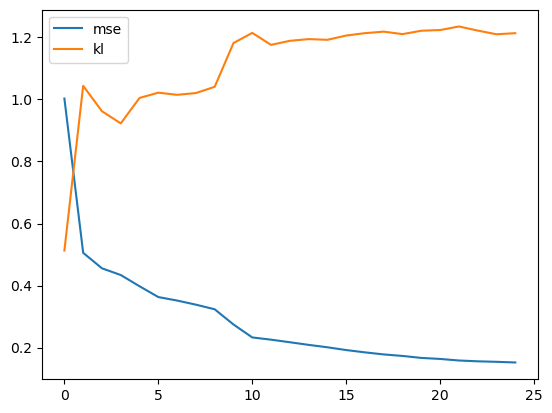

In [32]:
plt.plot(trainer.eval_losses['mse'], label='mse')
plt.plot(trainer.eval_losses['kl'], label='kl')
plt.legend()
plt.show()

In [42]:
from dataclasses import dataclass, asdict, field

In [44]:
log_dict = {
    "training_config" : asdict(trainer.config), 
}
for phase in trainer.phases:
    log_dict[f'{phase}_loss'] = trainer.losses[phase]
if(trainer.config.log_gradients):
    log_dict['gradients'] = trainer.gradients


In [48]:
log_dict['eval_loss'] = trainer.eval_losses

In [49]:
with open(os.path.join(trainer.dirs['log_dir'], "trial_log.json"), 'w') as f:
    json.dump(log_dict, f)


In [50]:
import json
fname = os.path.join(trainer.dirs['log_dir'], 'trial_log.json')
with open(file, 'r') as f:
    #text = f.read()
    flog = json.load(f)



In [51]:
flog

{'training_config': {'model_type': 'VAE',
  'run_id': 'vae',
  'num_channels': 128,
  'latent_dims': 16,
  'ae_hidden_dims': [64, 32, 16],
  'dataset_type': 'ClimsimDataset',
  'data_base_path': 'gs://leap-persistent/sammyagrawal/',
  'train_test_split': [0.01, 0.005],
  'data_paths': ['gs://leap-persistent/sammyagrawal/input_climsim.npy',
   'gs://leap-persistent/sammyagrawal/output_climsim.npy'],
  'data_vars': 'v1',
  'xarr_subsamples': [36, 210240, 144],
  'optimizer': 'adam',
  'phases': ['train'],
  'distributed_training': False,
  'shuffle_data': {'train': True, 'eval': False},
  'batch_size': 64,
  'learning_rate': 0.0003,
  'beta': 0.05,
  'save_best_epoch': True,
  'batch_logging_interval': 20,
  'log_gradients': True},
 'train_loss': {'mse': [0.9963384985923767,
   1.0454754143953324,
   0.9994485735893249,
   1.0307837963104247,
   0.9755004122853279,
   1.0034153401851653,
   0.9820222645998001,
   0.9056927561759949,
   0.7475230395793915,
   0.7164007723331451,
   0.6858

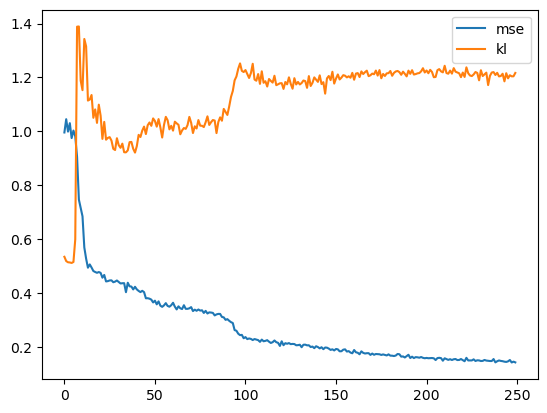

In [30]:
plt.plot(trainer.losses['train']['mse'], label='mse')
plt.plot(trainer.losses['train']['kl'], label='kl')
plt.legend()
plt.show()

In [99]:
trainer._save_checkpoint(epoch=50, cid='e50_end')

Model saved at experiments/VAE_August05_07:09/e50_end-ckpt.pt


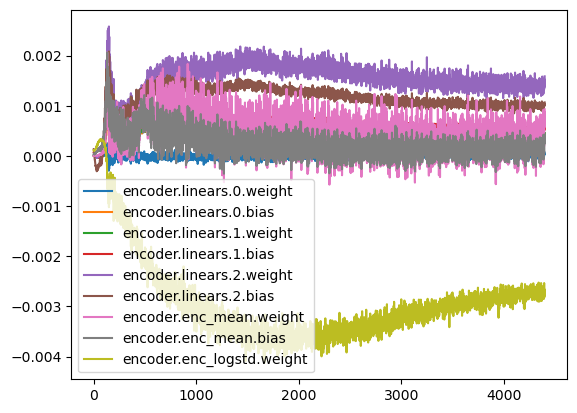

In [83]:
for name, p in trainer.model.named_parameters():
    if('encoder' in name):
        plt.plot(trainer.gradients['kl_gradients'][name], label=name)

plt.legend()
plt.show()

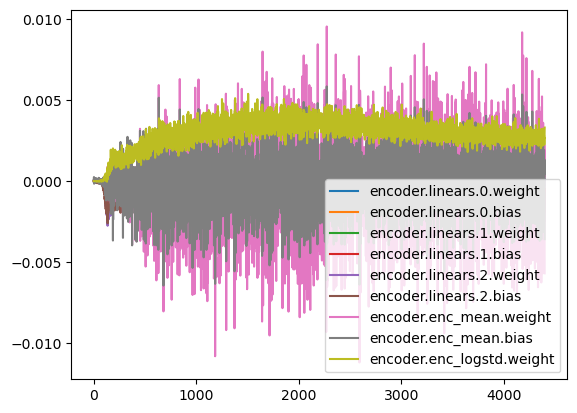

In [84]:
for name, p in trainer.model.named_parameters():
    if('encoder' in name):
        plt.plot(trainer.gradients['mse_gradients'][name], label=name)

plt.legend()
plt.show()

In [89]:
for name, p in trainer.model.named_parameters():
    print(f"{name} : {p.mean()} max: {p.max()}")


encoder.linears.0.weight : -0.0008597832638770342 max: 0.28049272298812866
encoder.linears.0.bias : 0.13973814249038696 max: 0.5375189185142517
encoder.linears.1.weight : 0.017588872462511063 max: 0.2839224338531494
encoder.linears.1.bias : 0.08965398371219635 max: 0.3107488453388214
encoder.linears.2.weight : 0.025787604972720146 max: 0.3266242742538452
encoder.linears.2.bias : 0.02053392492234707 max: 0.2269056737422943
encoder.enc_mean.weight : 0.0027831317856907845 max: 0.3772619962692261
encoder.enc_mean.bias : -0.041116077452898026 max: 0.25638166069984436
encoder.enc_logstd.weight : -0.01671697199344635 max: 0.37044861912727356
decoder.linears.0.weight : 0.013141201809048653 max: 0.6132853031158447
decoder.linears.0.bias : 0.2713344395160675 max: 0.5430784225463867
decoder.linears.1.weight : 0.06048228591680527 max: 0.5305845737457275
decoder.linears.1.bias : 0.06941613554954529 max: 0.37649983167648315
decoder.linears.2.weight : 0.017376843839883804 max: 0.47773420810699463
dec

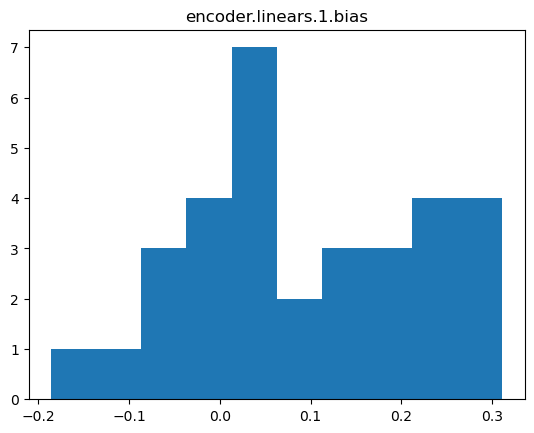

In [98]:
params = list(model.named_parameters())
i = 3
plt.hist(params[i][1].flatten().detach().cpu().numpy())
plt.title(params[i][0])
plt.show()

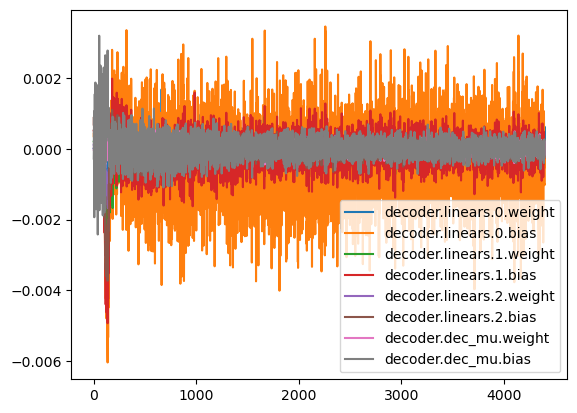

In [86]:
for name, p in trainer.model.named_parameters():
    if('decoder' in name):
        plt.plot(trainer.gradients['mse_gradients'][name], label=name)

plt.legend()
plt.show()

In [ ]:
for p in trainer.model.parameters():
    print(torch.linalg.norm(p.grad))

In [102]:
def eval_epoch(trainer):
    mse_loss, kl_div = 0.0, 0.0
    model.train(False)
    with torch.set_grad_enabled(False):
        for step, batch in enumerate(trainer.dataloaders['eval']):
            x_hat, mse, kl = trainer._run_batch(batch, 'eval')
            mse_loss += mse.item()
            kl_div += kl.item()
    
    return(mse_loss / len(trainer.dataloaders['eval']), kl_div / len(trainer.dataloaders['eval']))

In [103]:
eval_epoch(trainer)

(0.16288862919265573, 1.1357817378911106)

#### Testing Manually:

In [ ]:
dl = trainer.dataloaders['train']

In [ ]:
batch = next(iter(dl))
batch.shape

In [ ]:
loss_fn(trainer.model(batch, sample=False), trainer.model(batch, sample=True))

In [ ]:
loss_fn(batch, trainer.model(batch, sample=False)) #* config.batch_size

In [ ]:
dl.batch_size

In [ ]:
model = trainer.model
grads = {}
kls = []

In [ ]:
for epoch in range(15):
    print(epoch)
    for step, batch in enumerate(dl):
        optim.zero_grad()
        #mu, sigma = model.encoder(batch)
        #model.encoder.kl.backward()
        x_hat = model(batch, sample=False)
        loss = loss_fn(x_hat, batch)
        loss.backward()
        optim.step()
        if(step % 40 == 0):
            print(f"Step {step} loss {loss.item()}")
            for name, param in model.encoder.named_parameters():
                if name not in grads.keys():
                    grads[name] = []
                grads[name].append(param.grad.mean().item())
            kls.append(model.encoder.kl.item())
    

In [ ]:
for name, param in model.encoder.named_parameters():
    print(name, param.grad.mean())
    

In [ ]:
optim

In [ ]:
for name, curve in grads.items():
    plt.plot(curve, label=name)

plt.legend()
plt.show()

In [ ]:
plt.plot(kls)

In [ ]:
mu, sigma = model.encoder(bch)

In [ ]:
(sigma**2 + mu**2 - torch.log(sigma) - 1/2).shape

## Breaking down these functions

In [ ]:
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
ds_in = xr.open_dataset(mapper, engine='zarr', chunks={})
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds_out = xr.open_dataset(mapper, engine='zarr', chunks={})

input_vars, output_vars = load_vars('v1', tendencies=False)

In [ ]:
ds_in = ds_in.isel(sample=slice(36,210240, 144))[input_vars]
ds_out = ds_out.isel(sample=slice(36, 210240, 144))[output_vars]

In [ ]:
mli = ds_in.to_stacked_array('mli', sample_dims=['sample', 'ncol']).mli
mlo = ds_out.to_stacked_array('mlo', sample_dims=['sample', 'ncol']).mlo
state = ds_in.stack({'state' : ['sample', 'ncol']}).state

In [ ]:
Xarr = xr.DataArray(X, dims=['state', 'mli'], coords={'state' : state, 'mli':mli})
Yarr = xr.DataArray(Y, dims=['state', 'mlo'], coords={'state' : state, 'mlo':mlo})


In [ ]:
image_dataset = ClimsimImageDataset(Xarr, Yarr)

In [ ]:
ys = image_dataset.reconstruct_Y(image_dataset[0])[59]
plt.imshow(ys)
plt.colorbar()
plt.show()

# Training Loop + Variations

In [ ]:
from dataclasses import dataclass, asdict, field

In [ ]:
@dataclass
class TrainingConfig:
    model_type: str = "VAE"
    num_channels: int = 128
    latent_dims: int = 16
    ae_hidden_dims: list = [64, 32, 16]
    dataset_type: str = "ClimsimDataset"

    data_base_path: str = "gs://leap-persistent/sammyagrawal/"
    data_paths: list = [data_base_path + "input_climsim.npy", data_base_path + "output_climsim.npy"]
    data_vars: str = 'v1'
    dataset_subsamples: tuple = (36,210240, 144)
    
    num_epochs: int = 10
    shuffle_data: dict = None
    batch_size: int = 8
    learning_rate: float = 1e-3
    beta: int = 0.5
    batch_logging_interval: int = 2
    
    def __post_init__(self):
        self.shuffle_data = {'train':False, 'eval':False}

config = TrainingConfig()
config

In [ ]:
import json

with open("config.json", 'w') as f:
    json.dump(asdict(config), f)

In [ ]:
with open("config.json", 'r') as f:
    config_dict = json.load(f)
config_dict

In [ ]:
TrainingConfig(**config_dict)

In [ ]:
d.keys()

In [ ]:
Xarr

In [ ]:
datasets = {
    "train" : ClimsimDataset(Xarr.isel(state=slice(0, 64)), Yarr.isel(state=slice(0, 64))),
    "eval" : ClimsimDataset(Xarr.isel(state=slice(100, 164)), Yarr.isel(state=slice(100, 164)))
}

In [ ]:
optimizer = torch.optim.SGD(VAE.parameters(), lr=config.learning_rate)

### Want to reoad these objects as needed

In [ ]:
import 

In [ ]:
num_samples = Xarr.shape[0]

In [ ]:
type(Xarr)

In [ ]:
def load_training_objects(config=TrainingConfig()):
    model = VariationalAutoencoder(data_dims=128, latent_dims=16, hidden_dims=[64, 32, 16])
    datasets = {
        "train" : ClimsimDataset(Xarr.isel(state=slice(0, 64)), Yarr.isel(state=slice(0, 64))),
        "eval" : ClimsimDataset(Xarr.isel(state=slice(100, 164)), Yarr.isel(state=slice(100, 164)))
    }
    optimizer = torch.optim.SGD(VAE.parameters(), lr=config.learning_rate)
    
    loss_fn = nn.MSELoss()

    return(model, datasets, loss_fn, optimizer)

#### Vanilla bare bones training loop

In [ ]:
torch.is_grad_enabled()

In [ ]:
def vanilla_loop(model, datasets, loss_fn, optimizer, config):
    for phase in ['train', 'eval']:
        print(f"Entering {phase} phase") 
        dataloader = DataLoader( # add more args for data parallel or whatever down the line
            datasets[phase], shuffle=config.shuffle_data, batch_size=config.batch_size,
        )
        model.train(phase == 'train')
        with torch.set_grad_enabled(phase == 'train'):
            for epoch in range(config.num_epochs[phase]): # only run 1 epoch in validation
                for batch, x in enumerate(dataloader):
                    x_hat = model(x)
                    loss = loss_fn(x, x_hat) + config.beta * model.encoder.kl
                    if(phase == 'train'):
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                    if batch % config.batch_logging_interval == 0:
                        print(f"loss: {loss.item():>7f}  [epoch: {epoch}, batch: {batch}/{len(dataloader)}]")
                

In [ ]:
vanilla_loop(VAE, datasets, nn.MSELoss(), optimizer, config)

## Implementing More Advanced Training

Can take inspiration from various Pytorch tutorials
- [This one](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) on vision
- Comp Robotics [submission](https://www.gradescope.com/courses/723899/assignments/4402238/submissions/252277662#Question_3.5-rubric)

In [ ]:
from abc import ABC, abstractmethod
import datetime

In [ ]:
@dataclass
class TrainingConfig:
    num_epochs = 5
    shuffle_data = {'train':False, 'eval':False}
    batch_size = 8
    learning_rate = 1e-3
    beta = 0.5
    batch_logging_interval = 2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = TrainingConfig()

In [57]:
class VAETrainer(AbstractTrainer):
    def __init__(self, config=TrainingConfig(), exp_id='VAE'):
        super().__init__(config, exp_id)
        if(not hasattr(config, "beta")):
            self.config.beta = 0.4

    def _run_batch(self, batch, phase):
        x_hat = self.model(batch)
        loss = self.loss_fn(batch, x_hat) + self.config.beta * self.model.encoder.kl
        
        if(phase == 'train'):
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return(x_hat, loss)

    def setup_training(self, num_epochs):
        super().setup_training(num_epochs)
        self.losses = {'train': [], 'eval': []}

    def _run_epoch(self, epoch):
        losses = {}
        for phase, dataloader in self.dataloaders.items():
            losses[phase] = 0
            #print(f"\nEntering {phase} phase\n{'_' * 20}") 
            self.model.train(phase == 'train')
            with torch.set_grad_enabled(phase == 'train'):
                for step, batch in enumerate(dataloader):
                    x_hat, loss = self._run_batch(batch, phase)
                    losses[phase] += loss.item()
                    #if(step % config.batch_logging_interval == 0 and phase=='train'):
                    #    print(f"training loss: {loss.item():>7f}  [epoch: {epoch}, batch: {step}/{len(dataloader)}]")
            losses[phase] = losses[phase] / len(dataloader) # average loss per batch
        return(losses)

    def _log_epoch_info(self, epoch_num, epoch_stats):
        # epoch_stats is a dictionary with average loss per phase
        for phase, loss_val in epoch_stats.items():
            print(f"{phase} loss: {loss_val}")
            self.losses[phase].append(loss_val)
        

NameError: name 'AbstractTrainer' is not defined

In [ ]:
VAE, datasets, loss_fn, optimizer = load_objects()

In [ ]:
fake = AbstractTrainer(VAE, datasets, loss_fn, optimizer, config, 'testVAE')

In [ ]:
trainer = VAETrainer(VAE, datasets, loss_fn, optimizer, config)

In [ ]:
trainer.train()

In [ ]:
plt.plot(trainer.losses['train'], label='Training')
plt.plot(trainer.losses['eval'], label='Evaluation')
plt.legend()
plt.show()

#### Testing Tensorboard Logging

Pytorch [Tensorboard tutorial](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)

Tensorboard [docs](https://pytorch.org/docs/stable/tensorboard.html) specify what kind of things you can log: 

Basics of inline notebook tensorboard : [link](https://www.dlology.com/blog/how-to-run-tensorboard-for-pytorch-110-inside-jupyter-notebook/)

In [ ]:
import tensorboard

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='logs/')

In [ ]:
writer.flush()
writer.close()

[Too many plugins debug](https://stackoverflow.com/questions/57228487/valueerror-duplicate-plugins-for-name-projector)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs

### Distributed Training

DistributedSampler [source code](https://github.com/pytorch/pytorch/blob/main/torch/utils/data/distributed.py#L68)

- Data utils [docs](https://pytorch.org/docs/stable/data.html#memory-pinning)

In [ ]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
#from torch.distributed import init_process_group, destroy_process_group

In [ ]:
@dataclass
class DistributedTrainingConfig:
    num_epochs = 5
    shuffle_data = {'train':False, 'eval':False}
    batch_size = 8
    learning_rate = 1e-3
    beta = 0.5
    batch_logging_interval = 2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    world_size = torch.cuda.device_count()

dconfig = DistributedTrainingConfig()

In [ ]:
config.distributed = (torch.cuda.device_count() > 1)

In [ ]:
"MASTER_ADDR" in os.environ.keys()

In [ ]:
from climsim_training_utils import fetch_config